In [1]:
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 

In [3]:
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Read dataset 

df = pd.read_csv('data.csv', encoding ='latin')

In [5]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


In [6]:
# There are null values in location column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [7]:
# There 41157 rows and 6 columns in our database
df.shape

(41157, 6)

In [8]:
# All tweets came only from March and April month of 2020.
df.TweetAt.value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

In [9]:
# There are 12220 unique locations from where the tweets came.
df['Location'].value_counts()

London                       540
United States                528
London, England              520
New York, NY                 395
Washington, DC               373
                            ... 
Stockton-on-Tees, England      1
Waitsfield, VT                 1
swansea                        1
Chicago/Los Angeles            1
Mesa                           1
Name: Location, Length: 12220, dtype: int64

In [10]:
# There are 5 unique sentiment types in our dataset
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [11]:
df[df['Sentiment']=='Extremely Negative']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative
20,3819,48771,southampton soxx xxx,16-03-2020,with 100 nations inficted with covid 19 the world must not play fair with china 100 goverments must demand china adopts new guilde lines on food safty the chinese goverment is guilty...,Extremely Negative
27,3826,48778,Everywhere You Are!,16-03-2020,"This morning I tested positive for Covid 19. I feel ok, I have no symptoms so far but have been isolated since I found out about my possible exposure to the virus. Stay home people and be pragmat...",Extremely Negative
29,3828,48780,"Someplace, USA",16-03-2020,@7SealsOfTheEnd Soon with dwindling supplies unlawful Panicky people will be breaking into Closed Stores &amp; Supermarkets to Raid them as they normally do during a Crisis so massive as the #Coro...,Extremely Negative
42,3841,48793,Houston,16-03-2020,CHECK VIDEO ?? https://t.co/1ksn9Brl02 ??No food ? in USA market due to coronavirus panic we gonna die from starvation #CoronavirusOutbreak #coronavirus #houston #nofood #Notoiletpaper #NoHandShak...,Extremely Negative
...,...,...,...,...,...,...
41115,44914,89866,NaN,14-04-2020,"Food Banks are not equipped for a 30% unemployment rate. The federal government must provide direct aid to everyone, very quickly.\r\r\n\r\r\n""The Coronavirus Food Bank Crisis Is Already Underway""...",Extremely Negative
41128,44927,89879,"Melbourne, Australia",14-04-2020,"The COVID-19 pandemic and global oil price wars are having an economic impact worldwide, but one consequence is lower fuel prices at Australian petrol pumps for the foreseeable.\r\r\n\r\r\n#UniMel...",Extremely Negative
41130,44929,89881,NaN,14-04-2020,Squeo works in the meat department of a Kroger supermarket in Michigan. He knows of several grocery workers whoÂve tested positive for COVID-19 and one in his area who died. He worries that the b...,Extremely Negative
41133,44932,89884,Austria,14-04-2020,A Singaporean politician who slammed a woman snapped with seven supermarket trolleys during COVID-19 lockdown has been forced to eat humble pie after it turned out she was donating goods to the po...,Extremely Negative


In [12]:
df[df['Sentiment']=='Extremely Negative'].loc[20,'OriginalTweet']

'with 100  nations inficted with  covid  19  the world must  not  play fair with china  100 goverments must demand  china  adopts new guilde  lines on food safty  the  chinese  goverment  is guilty of  being  irosponcible   with life  on a global scale'

In [13]:
df[df['Sentiment']=='Negative']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our h...",Negative
24,3823,48775,Downstage centre,16-03-2020,@10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checko...,Negative
26,3825,48777,"Ketchum, Idaho",16-03-2020,"In preparation for higher demand and a potential food shortage, The Hunger Coalition purchased 10 percent more food and implemented new protocols due to the COVID-19 coronavirus. https://t.co/5Cec...",Negative
28,3827,48779,"New York, NY",16-03-2020,Do you see malicious price increases in NYC? The NYC Department of Consumer and Worker Protection (DCWP) has set up a page to digitally file a complaint. Click here: https://t.co/oEx6Y8mm2K\r\r\n\...,Negative
30,3829,48781,NaN,16-03-2020,There Is of in the Country The more empty shelves people see the more buying ensues the more food is out of stock,Negative
...,...,...,...,...,...,...
41127,44926,89878,NaN,14-04-2020,Today at the grocery store I saw someone getting a case of #Corona beer and I was about to jokingly say 'hey man i see you got Corona' then I stopped myself doing that thinking it would be the new...,Negative
41131,44930,89882,"Accra, Ghana",14-04-2020,"In every human affliction there are gainers and losers. In this case of Covid 19, the TELECOS are gaining beyond expectations. The level of internet being used at this moment is mind blowing. Gov...",Negative
41147,44946,89898,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?? #COVID19 #coronavirus #toiletpaper,Negative
41149,44948,89900,"Toronto, Ontario",14-04-2020,"Still shocked by the number of #Toronto supermarket employees working without some sort of mask. We all know by now, employees can be asymptomatic while spreading #coronavirus .",Negative


In [14]:
df[df['Sentiment']=='Negative'].loc[41149,'OriginalTweet']

'Still shocked by the number of #Toronto supermarket employees working without some sort of mask. We all know by now, employees can be asymptomatic while spreading #coronavirus .'

In [15]:
pd.isnull(df["Sentiment"])

0        False
1        False
2        False
3        False
4        False
         ...  
41152    False
41153    False
41154    False
41155    False
41156    False
Name: Sentiment, Length: 41157, dtype: bool

# Counting sentiment

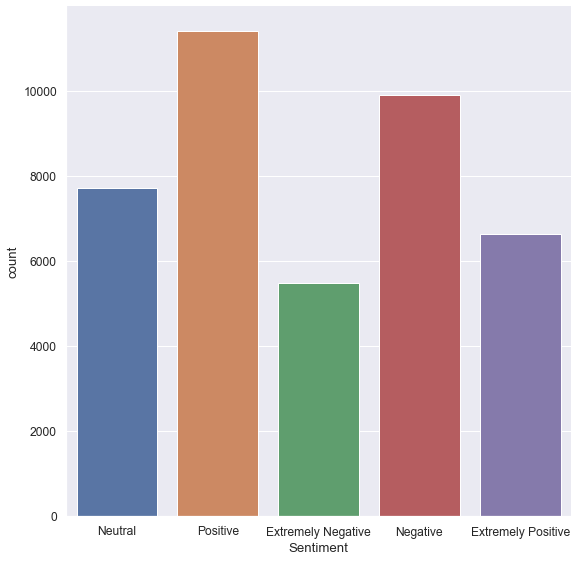

In [16]:
sns.set(font_scale=1.1)
sns.catplot("Sentiment", data=df, kind="count", height=8)

# Data Preprocessing

In [17]:
# function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [18]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [19]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...


In [20]:
# Remove link http 

import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [21]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [22]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

In [23]:
# Stemming 

from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [24]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

In [25]:
df['Tweet']  = tokenized_tweet

In [26]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order


# Extract feature from cleaned data 

In [27]:
new_df = df[['Tweet','Sentiment']]

In [28]:
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,"coronaviru australia: woolworth give elderly, disabl dedic shop hour amid covid-19 outbreak",Positive
3,"food stock not the onli one which empty... please, don't panic, there will enough food for everyon you not take more than you need. stay calm, stay safe. #covid19fr #covid_19 #covid19 #coronaviru ...",Positive
4,"me, readi supermarket dure the #covid19 outbreak. not becaus i'm paranoid, but becaus food stock litterali empty. the #coronaviru seriou thing, but please, don't panic. caus shortage... #coronavir...",Extremely Negative


In [29]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [30]:
# convert to lower case 

new_df["Tweet"] = new_df["Tweet"].str.lower()#.str.split()

In [31]:
# Remove stopword 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vibloteam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [33]:
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                             []
1        [v, c,  , l, k,  , u, r,  , n, e, g, h, b, u, r,  , f, l,  , e, x, c, h, n, g,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e,  , c, n, c,  , l,  , w, h,  , p, h, n, e,  , n, u, b, e, r,  , n, e, g, ...
2                                             [c, r, n, v, r, u,  , u, r, l, :,  , w, l, w, r, h,  , g, v, e,  , e, l, e, r, l, ,,  , b, l,  , e, c,  , h, p,  , h, u, r,  ,  , c, v, -, 1, 9,  , u, b, r, e, k]
3        [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e,  , w, h, c, h,  , e, p, ., ., .,  , p, l, e, e, ,,  , n, ',  , p, n, c, ,,  , h, e, r, e,  , w, l, l,  , e, n, u, g, h,  , f,  , f, r,  , e, v, e, r, ...
4        [e, ,,  , r, e,  , u, p, e, r, r, k, e,  , u, r, e,  , h, e,  , #, c, v, 1, 9,  , u, b, r, e, k, .,  , n,  , b, e, c, u,  , ',  , p, r, n, ,,  , b, u,  , b

In [34]:
new_df.head(6)

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,"coronaviru australia: woolworth give elderly, disabl dedic shop hour amid covid-19 outbreak",Positive
3,"food stock not the onli one which empty... please, don't panic, there will enough food for everyon you not take more than you need. stay calm, stay safe. #covid19fr #covid_19 #covid19 #coronaviru ...",Positive
4,"me, readi supermarket dure the #covid19 outbreak. not becaus i'm paranoid, but becaus food stock litterali empty. the #coronaviru seriou thing, but please, don't panic. caus shortage... #coronavir...",Extremely Negative
5,"news the regionâ first confirm covid-19 case came out sullivan counti last week, peopl flock area store purchas clean supplies, hand sanitizer, food, toilet paper and other goods, report",Positive


# Convert to binary class

In [35]:
convert_df = new_df[['Tweet','Sentiment']]

In [36]:
convert_df["Sentiment"]= convert_df["Sentiment"].replace('Positive',1) 
convert_df["Sentiment"]= convert_df["Sentiment"].replace('Extremely Positive',1) 
convert_df["Sentiment"]= convert_df["Sentiment"].replace('Neutral',1) 
convert_df["Sentiment"]= convert_df["Sentiment"].replace('Negative',0) 
convert_df["Sentiment"]= convert_df["Sentiment"].replace('Extremely Negative',0) 

In [37]:
X = convert_df.drop('Sentiment', axis=1)
y = convert_df.Sentiment

In [38]:
y.value_counts()

1    25759
0    15398
Name: Sentiment, dtype: int64

# Train test split 

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(convert_df.Tweet.values, convert_df.Sentiment.values,test_size = 0.2,random_state=0)

print("train shape : ", X_train.shape, y_train.shape)
print("valid shape : ", X_valid.shape, y_valid.shape)

train shape :  (32925,) (32925,)
valid shape :  (8232,) (8232,)


In [40]:
X_train[0]

"the defin moment the covid-19 zombi apocalyps wa wit retard fuckwits, strip the supermarket shelv bare perish &amp; then the bin men' photo them thrown away. realli live amongst idiots!"

In [41]:
y_train[0]

0

# Feature Encoder

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [43]:
X_train = vectorizer.fit_transform(X_train)
X_valid = vectorizer.transform(X_valid)

In [44]:
X_train

<32925x35938 sparse matrix of type '<class 'numpy.float64'>'
	with 717550 stored elements in Compressed Sparse Row format>

# Traing KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train,y_train)

knn_prediction = knn_clf.predict(X_valid)
knn_accuracy = accuracy_score(y_valid,knn_prediction)
print("training accuracy Score    : ",knn_clf.score(X_train,y_train))
print("Validation accuracy Score : ",knn_accuracy )
print(classification_report(knn_prediction, y_valid))

training accuracy Score    :  0.716294608959757
Validation accuracy Score :  0.6209912536443148
              precision    recall  f1-score   support

           0       0.14      0.48      0.22       920
           1       0.91      0.64      0.75      7312

    accuracy                           0.62      8232
   macro avg       0.52      0.56      0.48      8232
weighted avg       0.82      0.62      0.69      8232



# Training Ramdom Forest 

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  0.9985421412300683
Validation accuracy Score :  0.7965257531584062
              precision    recall  f1-score   support

           0       0.56      0.84      0.67      2055
           1       0.94      0.78      0.85      6177

    accuracy                           0.80      8232
   macro avg       0.75      0.81      0.76      8232
weighted avg       0.84      0.80      0.81      8232



# Training Logistic Regression 

In [47]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.8786028853454821
Validation accuracy Score :  0.8288386783284742
              precision    recall  f1-score   support

           0       0.66      0.85      0.74      2367
           1       0.93      0.82      0.87      5865

    accuracy                           0.83      8232
   macro avg       0.79      0.84      0.81      8232
weighted avg       0.85      0.83      0.83      8232



# Training SVM

In [48]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9808656036446469
Validation accuracy Score :  0.8400145772594753
              precision    recall  f1-score   support

           0       0.67      0.87      0.76      2379
           1       0.94      0.83      0.88      5853

    accuracy                           0.84      8232
   macro avg       0.81      0.85      0.82      8232
weighted avg       0.86      0.84      0.85      8232



# Training Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()

dt_clf.fit(X_train,y_train)

dt_prediction = dt_clf.predict(X_valid)
dt_accuracy = accuracy_score(y_valid,dt_prediction)
print("Training accuracy Score    : ",dt_clf.score(X_train,y_train))
print("Validation accuracy Score : ",dt_accuracy )
print(classification_report(dt_prediction, y_valid))

Training accuracy Score    :  0.9985421412300683
Validation accuracy Score :  0.7491496598639455
              precision    recall  f1-score   support

           0       0.66      0.67      0.66      3043
           1       0.80      0.80      0.80      5189

    accuracy                           0.75      8232
   macro avg       0.73      0.73      0.73      8232
weighted avg       0.75      0.75      0.75      8232



In [50]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'KNN', 
              'Decision Tree'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, knn_accuracy, 
              dt_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
0,Support Vector Machines,0.840015
1,Logistic Regression,0.828839
2,Random Forest,0.796526
4,Decision Tree,0.749150
3,KNN,0.620991
